# Глава 1. Полносвязные нейронные сети

## Часть 4. Тонкая настройка нейронной сети

* Batch Normalization

* Инициализация весов

* Регуляризация (l2 и дропаут)

* Функция активации ReLu для борьбы с затуханием градиента

* Использование ансамбля нейросетей (для самостоятельной проработки)

* Использованием стэкинга нейросетей (для самостоятельной проработки)

## 1. Задача классификации

Воспользуемся тестовым примером, два класса, имеюшие форму концентрических окружностей. Функция позволяет создавать вариации датасета с разным уровнем шума.

Это хорошая тестовая задача, потому что классы не линейно разделимы, что требует нелинейного метода, такого как нейронная сеть

In [43]:
from sklearn.datasets import make_circles

In [44]:
from numpy import where
from matplotlib import pyplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [45]:
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

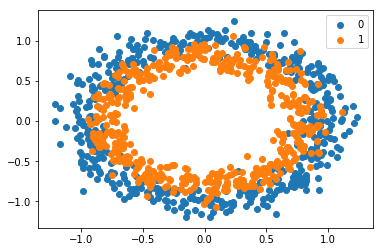

In [46]:
for i in range(2):
    samples_ix = where(y == i)
    pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

##  2.1 Многослойный перцептрон

Попробуем модель многослойного перцептрона (MLP) в качестве основной модели для решения этой задачи.

Сначала мы разделим 1000 сгенерированных семплов данных для обучения и тестирования по 500 примеров в каждом. Это обеспечит достаточно большую выборку для обучения модели и достаточно справедливую оценку ее эффективности.

Модель будет иметь один скрытый слой с 50 нейронами и использовать ReLu функцию активации и метод инициализации начальных весов He (Ге). Выходным слоем будет отдельный узел с функцией активации сигмоида. При этом выход модели можно интерпретировать как вероятность принадлежности к классу 1.

Модель будет обучаться использованием стохастического градиентного спуска с небольшой скоростью обучения 0,01 и большим импульсом 0,9. В качестве функции потерь будем использовать бинарную кросс-энтропию.

In [47]:
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

In [48]:
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [49]:
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [51]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)

Train on 500 samples, validate on 500 samples
Epoch 1/100
500/500 [==============================] - 1s 1ms/step - loss: 0.7271 - acc: 0.5240 - val_loss: 0.7005 - val_acc: 0.4700
Epoch 2/100
500/500 [==============================] - 0s 82us/step - loss: 0.6812 - acc: 0.5120 - val_loss: 0.6919 - val_acc: 0.4980
Epoch 3/100
500/500 [==============================] - 0s 68us/step - loss: 0.6808 - acc: 0.5240 - val_loss: 0.6828 - val_acc: 0.5160
Epoch 4/100
500/500 [==============================] - 0s 73us/step - loss: 0.6728 - acc: 0.5540 - val_loss: 0.6780 - val_acc: 0.5240
Epoch 5/100
500/500 [==============================] - 0s 72us/step - loss: 0.6670 - acc: 0.5780 - val_loss: 0.6739 - val_acc: 0.5360
Epoch 6/100
500/500 [==============================] - 0s 63us/step - loss: 0.6662 - acc: 0.6020 - val_loss: 0.6664 - val_acc: 0.5400
Epoch 7/100
500/500 [==============================] - 0s 63us/step - loss: 0.6589 - acc: 0.5940 - val_loss: 0.6675 - val_acc: 0.5340
Epoch 8/100
500/5

In [52]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

In [53]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.850


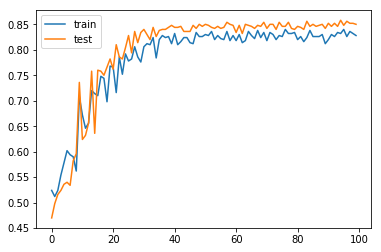

In [54]:
# plot history
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

## 2.2 MLP с BatchNormalization

**Бэтч нормализация** - это метод нормализации (стандартизации) внутреннего представления данных для ускорения обучения.

* Метод решает следующую проблему, препятствующую эффективному обучению нейронных сетей

* По мере распространения сигнала по сети, даже если мы нормализовали его на входе, пройдя через внутренние слои, он может сильно исказиться как по матожиднию, так и по дисперсии (данное явление называется внутренним ковариационным сдвигом), что чревато серьезными несоответствиями между градиентами на различных уровнях. Из-за этого нам приходится использовать более сильные регуляризаторы, замедляя тем самым темп обучения.

**Батч-нормализация** -предлагает весьма простое решение данной проблемы: нормализовать входные данные таким образом, чтобы получить нулевое матожидание и единичную дисперсию. 

Нормализация выполняется перед входом в каждый слой. Это значит, что во время обучения мы нормализуем batch_size примеров, а во время тестирования мы нормализуем статистику, полученную на основе всего обучающего множества, так как увидеть заранее тестовые данные мы не можем.

![title](img/ann23.png)

Обновим модель с добавлением бэтч нормализации

Ожидается, что добавление нормализации бэтча ускорит процесс обучения, обеспечивая аналогичную или лучшую точность классификации модели в меньшем количестве эпох обучения. 

Бэтч нормализация обеспечивает слабую форму регуляризации, что означает, что она может также предложить небольшое снижение ошибки обобщения, продемонстрированное небольшим увеличением точности классификации в наборе тестовых данных.

Новый слой BatchNormalization можно добавить в модель после скрытого слоя перед выходным слоем. В частности, после активации функции предыдущего скрытого слоя.

In [55]:
from keras.layers import BatchNormalization

In [56]:
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [57]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)

Train on 500 samples, validate on 500 samples
Epoch 1/100
500/500 [==============================] - 1s 2ms/step - loss: 0.9676 - acc: 0.5160 - val_loss: 0.9107 - val_acc: 0.5420
Epoch 2/100
500/500 [==============================] - 0s 106us/step - loss: 0.6628 - acc: 0.6180 - val_loss: 0.5899 - val_acc: 0.6660
Epoch 3/100
500/500 [==============================] - 0s 103us/step - loss: 0.5494 - acc: 0.7560 - val_loss: 0.5323 - val_acc: 0.7580
Epoch 4/100
500/500 [==============================] - 0s 94us/step - loss: 0.4945 - acc: 0.8240 - val_loss: 0.5129 - val_acc: 0.7300
Epoch 5/100
500/500 [==============================] - 0s 98us/step - loss: 0.4787 - acc: 0.7880 - val_loss: 0.4901 - val_acc: 0.7560
Epoch 6/100
500/500 [==============================] - 0s 100us/step - loss: 0.4729 - acc: 0.7960 - val_loss: 0.4749 - val_acc: 0.7820
Epoch 7/100
500/500 [==============================] - 0s 99us/step - loss: 0.4825 - acc: 0.7900 - val_loss: 0.4971 - val_acc: 0.7400
Epoch 8/100
50

In [58]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

In [59]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.842, Test: 0.846


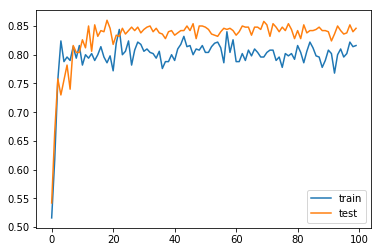

In [60]:
# plot history
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### Задание 1. 
* C бетой и гаммой. Обновите пример, чтобы посмотреть как влияют бета- и гамма-параметры в слое бэтч нормализации. Сравните результаты.

* С импульсом  (momentum). Обновите пример, чтобы посмотреть как влияет импульс в слое бэтч нормализации во время обучения. Сравните результаты.

* Входной слой. Обновите пример, чтобы использовать бэтч нормализацию после входных параметров в модели. Сравнить результаты.

Литература

Sergey Ioffe, Christian Szegedy.  Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (https://arxiv.org/abs/1502.03167)

## 3. Регуляризация для нейронных сетей

## 3.1 MLP без регуляризации Dropout

* Главная идея Dropout — вместо обучения одной DNN обучить ансамбль нескольких DNN, а затем усреднить полученные результаты.

* Сети для обучения получаются с помощью исключения из сети (dropping out) нейронов с вероятностью , таким образом, вероятность того, что нейрон останется в сети, составляет . “Исключение” нейрона означает, что при любых входных данных или параметрах он возвращает 0.

* Исключенные нейроны не вносят свой вклад в процесс обучения ни на одном из этапов алгоритма обратного распространения ошибки (backpropagation); поэтому исключение хотя бы одного из нейронов равносильно обучению новой нейронной сети.

* В двух словах, Dropout хорошо работает на практике, потому что предотвращает взаимоадаптацию нейронов на этапе обучения.

![title](img/ann19.jpeg)

In [85]:
import pandas as pd

In [86]:
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)

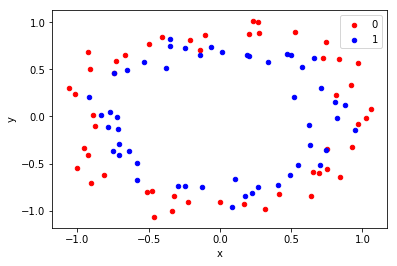

In [87]:
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [88]:
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)

n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

In [89]:
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=1)

Train on 30 samples, validate on 70 samples
Epoch 1/4000
30/30 [==============================] - 2s 59ms/step - loss: 0.6941 - acc: 0.5333 - val_loss: 0.6951 - val_acc: 0.4857
Epoch 2/4000
30/30 [==============================] - 0s 135us/step - loss: 0.6908 - acc: 0.5667 - val_loss: 0.6967 - val_acc: 0.4714
Epoch 3/4000
30/30 [==============================] - 0s 446us/step - loss: 0.6876 - acc: 0.6333 - val_loss: 0.6984 - val_acc: 0.4857
Epoch 4/4000
30/30 [==============================] - 0s 155us/step - loss: 0.6846 - acc: 0.6333 - val_loss: 0.7002 - val_acc: 0.4857
Epoch 5/4000
30/30 [==============================] - 0s 263us/step - loss: 0.6817 - acc: 0.6333 - val_loss: 0.7020 - val_acc: 0.4857
Epoch 6/4000
30/30 [==============================] - 0s 273us/step - loss: 0.6789 - acc: 0.6000 - val_loss: 0.7039 - val_acc: 0.5000
Epoch 7/4000
30/30 [==============================] - 0s 485us/step - loss: 0.6763 - acc: 0.5667 - val_loss: 0.7058 - val_acc: 0.5000
Epoch 8/4000
30/30 

Epoch 62/4000
30/30 [==============================] - 0s 128us/step - loss: 0.5987 - acc: 0.6667 - val_loss: 0.7639 - val_acc: 0.4571
Epoch 63/4000
30/30 [==============================] - 0s 112us/step - loss: 0.5976 - acc: 0.6667 - val_loss: 0.7640 - val_acc: 0.4571
Epoch 64/4000
30/30 [==============================] - 0s 133us/step - loss: 0.5966 - acc: 0.6667 - val_loss: 0.7642 - val_acc: 0.4571
Epoch 65/4000
30/30 [==============================] - 0s 107us/step - loss: 0.5955 - acc: 0.6667 - val_loss: 0.7643 - val_acc: 0.4571
Epoch 66/4000
30/30 [==============================] - 0s 110us/step - loss: 0.5944 - acc: 0.6667 - val_loss: 0.7645 - val_acc: 0.4571
Epoch 67/4000
30/30 [==============================] - 0s 138us/step - loss: 0.5933 - acc: 0.6667 - val_loss: 0.7646 - val_acc: 0.4571
Epoch 68/4000
30/30 [==============================] - 0s 299us/step - loss: 0.5922 - acc: 0.7000 - val_loss: 0.7647 - val_acc: 0.4571
Epoch 69/4000
30/30 [==============================] - 

Epoch 123/4000
30/30 [==============================] - 0s 119us/step - loss: 0.5292 - acc: 0.7667 - val_loss: 0.7449 - val_acc: 0.5000
Epoch 124/4000
30/30 [==============================] - 0s 412us/step - loss: 0.5279 - acc: 0.7667 - val_loss: 0.7440 - val_acc: 0.5000
Epoch 125/4000
30/30 [==============================] - 0s 120us/step - loss: 0.5267 - acc: 0.7667 - val_loss: 0.7431 - val_acc: 0.5000
Epoch 126/4000
30/30 [==============================] - 0s 115us/step - loss: 0.5254 - acc: 0.7667 - val_loss: 0.7422 - val_acc: 0.5000
Epoch 127/4000
30/30 [==============================] - 0s 121us/step - loss: 0.5242 - acc: 0.7667 - val_loss: 0.7414 - val_acc: 0.5000
Epoch 128/4000
30/30 [==============================] - 0s 454us/step - loss: 0.5229 - acc: 0.7667 - val_loss: 0.7405 - val_acc: 0.5000
Epoch 129/4000
30/30 [==============================] - 0s 134us/step - loss: 0.5216 - acc: 0.7667 - val_loss: 0.7396 - val_acc: 0.5000
Epoch 130/4000
30/30 [==========================

Epoch 184/4000
30/30 [==============================] - 0s 124us/step - loss: 0.4493 - acc: 0.8333 - val_loss: 0.6750 - val_acc: 0.6000
Epoch 185/4000
30/30 [==============================] - 0s 131us/step - loss: 0.4480 - acc: 0.8333 - val_loss: 0.6738 - val_acc: 0.6000
Epoch 186/4000
30/30 [==============================] - 0s 131us/step - loss: 0.4468 - acc: 0.8333 - val_loss: 0.6726 - val_acc: 0.6000
Epoch 187/4000
30/30 [==============================] - 0s 127us/step - loss: 0.4455 - acc: 0.8333 - val_loss: 0.6715 - val_acc: 0.6000
Epoch 188/4000
30/30 [==============================] - 0s 129us/step - loss: 0.4442 - acc: 0.8333 - val_loss: 0.6703 - val_acc: 0.6000
Epoch 189/4000
30/30 [==============================] - 0s 132us/step - loss: 0.4430 - acc: 0.8333 - val_loss: 0.6692 - val_acc: 0.6143
Epoch 190/4000
30/30 [==============================] - 0s 121us/step - loss: 0.4417 - acc: 0.8333 - val_loss: 0.6680 - val_acc: 0.6143
Epoch 191/4000
30/30 [==========================

Epoch 245/4000
30/30 [==============================] - 0s 132us/step - loss: 0.3731 - acc: 0.8333 - val_loss: 0.5889 - val_acc: 0.6714
Epoch 246/4000
30/30 [==============================] - 0s 180us/step - loss: 0.3719 - acc: 0.8333 - val_loss: 0.5876 - val_acc: 0.6714
Epoch 247/4000
30/30 [==============================] - 0s 146us/step - loss: 0.3707 - acc: 0.8333 - val_loss: 0.5862 - val_acc: 0.6714
Epoch 248/4000
30/30 [==============================] - 0s 129us/step - loss: 0.3696 - acc: 0.8333 - val_loss: 0.5849 - val_acc: 0.6714
Epoch 249/4000
30/30 [==============================] - 0s 135us/step - loss: 0.3684 - acc: 0.8333 - val_loss: 0.5836 - val_acc: 0.6714
Epoch 250/4000
30/30 [==============================] - 0s 130us/step - loss: 0.3673 - acc: 0.8333 - val_loss: 0.5824 - val_acc: 0.6714
Epoch 251/4000
30/30 [==============================] - 0s 126us/step - loss: 0.3661 - acc: 0.8333 - val_loss: 0.5812 - val_acc: 0.6714
Epoch 252/4000
30/30 [==========================

Epoch 306/4000
30/30 [==============================] - 0s 132us/step - loss: 0.3073 - acc: 0.8667 - val_loss: 0.5176 - val_acc: 0.7143
Epoch 307/4000
30/30 [==============================] - 0s 128us/step - loss: 0.3063 - acc: 0.8667 - val_loss: 0.5165 - val_acc: 0.7143
Epoch 308/4000
30/30 [==============================] - 0s 143us/step - loss: 0.3053 - acc: 0.8667 - val_loss: 0.5155 - val_acc: 0.7143
Epoch 309/4000
30/30 [==============================] - 0s 134us/step - loss: 0.3043 - acc: 0.8667 - val_loss: 0.5145 - val_acc: 0.7143
Epoch 310/4000
30/30 [==============================] - 0s 151us/step - loss: 0.3034 - acc: 0.8667 - val_loss: 0.5136 - val_acc: 0.7143
Epoch 311/4000
30/30 [==============================] - 0s 130us/step - loss: 0.3024 - acc: 0.8667 - val_loss: 0.5127 - val_acc: 0.7143
Epoch 312/4000
30/30 [==============================] - 0s 147us/step - loss: 0.3014 - acc: 0.8667 - val_loss: 0.5118 - val_acc: 0.7143
Epoch 313/4000
30/30 [==========================

Epoch 367/4000
30/30 [==============================] - 0s 166us/step - loss: 0.2532 - acc: 0.9667 - val_loss: 0.4680 - val_acc: 0.7571
Epoch 368/4000
30/30 [==============================] - 0s 147us/step - loss: 0.2524 - acc: 0.9667 - val_loss: 0.4672 - val_acc: 0.7571
Epoch 369/4000
30/30 [==============================] - 0s 155us/step - loss: 0.2516 - acc: 0.9667 - val_loss: 0.4667 - val_acc: 0.7571
Epoch 370/4000
30/30 [==============================] - 0s 155us/step - loss: 0.2508 - acc: 0.9667 - val_loss: 0.4660 - val_acc: 0.7571
Epoch 371/4000
30/30 [==============================] - 0s 151us/step - loss: 0.2500 - acc: 0.9667 - val_loss: 0.4654 - val_acc: 0.7571
Epoch 372/4000
30/30 [==============================] - 0s 129us/step - loss: 0.2492 - acc: 0.9667 - val_loss: 0.4647 - val_acc: 0.7571
Epoch 373/4000
30/30 [==============================] - 0s 134us/step - loss: 0.2484 - acc: 0.9667 - val_loss: 0.4640 - val_acc: 0.7571
Epoch 374/4000
30/30 [==========================

Epoch 428/4000
30/30 [==============================] - 0s 135us/step - loss: 0.2109 - acc: 0.9667 - val_loss: 0.4448 - val_acc: 0.7857
Epoch 429/4000
30/30 [==============================] - 0s 121us/step - loss: 0.2103 - acc: 0.9667 - val_loss: 0.4446 - val_acc: 0.7857
Epoch 430/4000
30/30 [==============================] - 0s 152us/step - loss: 0.2097 - acc: 0.9667 - val_loss: 0.4445 - val_acc: 0.7857
Epoch 431/4000
30/30 [==============================] - 0s 115us/step - loss: 0.2091 - acc: 0.9667 - val_loss: 0.4446 - val_acc: 0.7857
Epoch 432/4000
30/30 [==============================] - 0s 147us/step - loss: 0.2085 - acc: 0.9667 - val_loss: 0.4447 - val_acc: 0.7857
Epoch 433/4000
30/30 [==============================] - 0s 132us/step - loss: 0.2080 - acc: 0.9667 - val_loss: 0.4449 - val_acc: 0.7857
Epoch 434/4000
30/30 [==============================] - 0s 131us/step - loss: 0.2074 - acc: 0.9667 - val_loss: 0.4449 - val_acc: 0.7857
Epoch 435/4000
30/30 [==========================

Epoch 489/4000
30/30 [==============================] - 0s 121us/step - loss: 0.1803 - acc: 0.9667 - val_loss: 0.4423 - val_acc: 0.8000
Epoch 490/4000
30/30 [==============================] - 0s 120us/step - loss: 0.1798 - acc: 0.9667 - val_loss: 0.4424 - val_acc: 0.8000
Epoch 491/4000
30/30 [==============================] - 0s 124us/step - loss: 0.1794 - acc: 0.9667 - val_loss: 0.4425 - val_acc: 0.8000
Epoch 492/4000
30/30 [==============================] - 0s 115us/step - loss: 0.1790 - acc: 0.9667 - val_loss: 0.4426 - val_acc: 0.8000
Epoch 493/4000
30/30 [==============================] - 0s 126us/step - loss: 0.1786 - acc: 0.9667 - val_loss: 0.4426 - val_acc: 0.8000
Epoch 494/4000
30/30 [==============================] - 0s 144us/step - loss: 0.1781 - acc: 0.9667 - val_loss: 0.4426 - val_acc: 0.8000
Epoch 495/4000
30/30 [==============================] - 0s 135us/step - loss: 0.1777 - acc: 0.9667 - val_loss: 0.4426 - val_acc: 0.8000
Epoch 496/4000
30/30 [==========================

Epoch 550/4000
30/30 [==============================] - 0s 130us/step - loss: 0.1572 - acc: 0.9667 - val_loss: 0.4477 - val_acc: 0.8143
Epoch 551/4000
30/30 [==============================] - 0s 131us/step - loss: 0.1569 - acc: 0.9667 - val_loss: 0.4478 - val_acc: 0.8143
Epoch 552/4000
30/30 [==============================] - 0s 129us/step - loss: 0.1566 - acc: 0.9667 - val_loss: 0.4479 - val_acc: 0.8143
Epoch 553/4000
30/30 [==============================] - 0s 149us/step - loss: 0.1563 - acc: 0.9667 - val_loss: 0.4479 - val_acc: 0.8143
Epoch 554/4000
30/30 [==============================] - 0s 156us/step - loss: 0.1559 - acc: 0.9667 - val_loss: 0.4480 - val_acc: 0.8143
Epoch 555/4000
30/30 [==============================] - 0s 126us/step - loss: 0.1556 - acc: 0.9667 - val_loss: 0.4481 - val_acc: 0.8143
Epoch 556/4000
30/30 [==============================] - 0s 136us/step - loss: 0.1553 - acc: 0.9667 - val_loss: 0.4482 - val_acc: 0.8143
Epoch 557/4000
30/30 [==========================

Epoch 611/4000
30/30 [==============================] - 0s 131us/step - loss: 0.1395 - acc: 0.9667 - val_loss: 0.4562 - val_acc: 0.8143
Epoch 612/4000
30/30 [==============================] - 0s 131us/step - loss: 0.1392 - acc: 0.9667 - val_loss: 0.4564 - val_acc: 0.8143
Epoch 613/4000
30/30 [==============================] - 0s 124us/step - loss: 0.1390 - acc: 0.9667 - val_loss: 0.4565 - val_acc: 0.8143
Epoch 614/4000
30/30 [==============================] - 0s 130us/step - loss: 0.1387 - acc: 0.9667 - val_loss: 0.4566 - val_acc: 0.8143
Epoch 615/4000
30/30 [==============================] - 0s 127us/step - loss: 0.1385 - acc: 0.9667 - val_loss: 0.4568 - val_acc: 0.8143
Epoch 616/4000
30/30 [==============================] - 0s 135us/step - loss: 0.1382 - acc: 0.9667 - val_loss: 0.4569 - val_acc: 0.8143
Epoch 617/4000
30/30 [==============================] - 0s 125us/step - loss: 0.1380 - acc: 0.9667 - val_loss: 0.4571 - val_acc: 0.8143
Epoch 618/4000
30/30 [==========================

Epoch 672/4000
30/30 [==============================] - 0s 125us/step - loss: 0.1254 - acc: 0.9667 - val_loss: 0.4665 - val_acc: 0.8286
Epoch 673/4000
30/30 [==============================] - 0s 121us/step - loss: 0.1252 - acc: 0.9667 - val_loss: 0.4666 - val_acc: 0.8286
Epoch 674/4000
30/30 [==============================] - 0s 122us/step - loss: 0.1250 - acc: 0.9667 - val_loss: 0.4668 - val_acc: 0.8286
Epoch 675/4000
30/30 [==============================] - 0s 125us/step - loss: 0.1248 - acc: 0.9667 - val_loss: 0.4669 - val_acc: 0.8286
Epoch 676/4000
30/30 [==============================] - 0s 141us/step - loss: 0.1246 - acc: 0.9667 - val_loss: 0.4670 - val_acc: 0.8286
Epoch 677/4000
30/30 [==============================] - 0s 119us/step - loss: 0.1244 - acc: 0.9667 - val_loss: 0.4672 - val_acc: 0.8286
Epoch 678/4000
30/30 [==============================] - 0s 123us/step - loss: 0.1242 - acc: 0.9667 - val_loss: 0.4674 - val_acc: 0.8286
Epoch 679/4000
30/30 [==========================

Epoch 733/4000
30/30 [==============================] - 0s 139us/step - loss: 0.1140 - acc: 0.9667 - val_loss: 0.4784 - val_acc: 0.8286
Epoch 734/4000
30/30 [==============================] - 0s 153us/step - loss: 0.1139 - acc: 0.9667 - val_loss: 0.4786 - val_acc: 0.8286
Epoch 735/4000
30/30 [==============================] - 0s 154us/step - loss: 0.1137 - acc: 0.9667 - val_loss: 0.4789 - val_acc: 0.8286
Epoch 736/4000
30/30 [==============================] - 0s 138us/step - loss: 0.1135 - acc: 0.9667 - val_loss: 0.4792 - val_acc: 0.8286
Epoch 737/4000
30/30 [==============================] - 0s 146us/step - loss: 0.1134 - acc: 0.9667 - val_loss: 0.4796 - val_acc: 0.8286
Epoch 738/4000
30/30 [==============================] - 0s 144us/step - loss: 0.1132 - acc: 0.9667 - val_loss: 0.4799 - val_acc: 0.8286
Epoch 739/4000
30/30 [==============================] - 0s 165us/step - loss: 0.1130 - acc: 0.9667 - val_loss: 0.4802 - val_acc: 0.8286
Epoch 740/4000
30/30 [==========================

Epoch 794/4000
30/30 [==============================] - 0s 140us/step - loss: 0.1047 - acc: 0.9667 - val_loss: 0.4973 - val_acc: 0.8286
Epoch 795/4000
30/30 [==============================] - 0s 134us/step - loss: 0.1045 - acc: 0.9667 - val_loss: 0.4976 - val_acc: 0.8286
Epoch 796/4000
30/30 [==============================] - 0s 131us/step - loss: 0.1044 - acc: 0.9667 - val_loss: 0.4980 - val_acc: 0.8286
Epoch 797/4000
30/30 [==============================] - 0s 138us/step - loss: 0.1043 - acc: 0.9667 - val_loss: 0.4983 - val_acc: 0.8286
Epoch 798/4000
30/30 [==============================] - 0s 147us/step - loss: 0.1041 - acc: 0.9667 - val_loss: 0.4987 - val_acc: 0.8286
Epoch 799/4000
30/30 [==============================] - 0s 136us/step - loss: 0.1040 - acc: 0.9667 - val_loss: 0.4991 - val_acc: 0.8286
Epoch 800/4000
30/30 [==============================] - 0s 128us/step - loss: 0.1038 - acc: 0.9667 - val_loss: 0.4994 - val_acc: 0.8286
Epoch 801/4000
30/30 [==========================

Epoch 855/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0966 - acc: 0.9667 - val_loss: 0.5181 - val_acc: 0.8429
Epoch 856/4000
30/30 [==============================] - 0s 157us/step - loss: 0.0965 - acc: 0.9667 - val_loss: 0.5184 - val_acc: 0.8429
Epoch 857/4000
30/30 [==============================] - 0s 150us/step - loss: 0.0964 - acc: 0.9667 - val_loss: 0.5187 - val_acc: 0.8429
Epoch 858/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0963 - acc: 0.9667 - val_loss: 0.5189 - val_acc: 0.8429
Epoch 859/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0961 - acc: 0.9667 - val_loss: 0.5193 - val_acc: 0.8429
Epoch 860/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0960 - acc: 0.9667 - val_loss: 0.5197 - val_acc: 0.8429
Epoch 861/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0959 - acc: 0.9667 - val_loss: 0.5201 - val_acc: 0.8429
Epoch 862/4000
30/30 [==========================

Epoch 916/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0894 - acc: 0.9667 - val_loss: 0.5380 - val_acc: 0.8286
Epoch 917/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0893 - acc: 0.9667 - val_loss: 0.5385 - val_acc: 0.8286
Epoch 918/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0892 - acc: 0.9667 - val_loss: 0.5389 - val_acc: 0.8286
Epoch 919/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0891 - acc: 0.9667 - val_loss: 0.5392 - val_acc: 0.8286
Epoch 920/4000
30/30 [==============================] - 0s 135us/step - loss: 0.0889 - acc: 0.9667 - val_loss: 0.5395 - val_acc: 0.8286
Epoch 921/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0888 - acc: 0.9667 - val_loss: 0.5398 - val_acc: 0.8286
Epoch 922/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0887 - acc: 0.9667 - val_loss: 0.5402 - val_acc: 0.8286
Epoch 923/4000
30/30 [==========================

Epoch 977/4000
30/30 [==============================] - 0s 104us/step - loss: 0.0825 - acc: 0.9667 - val_loss: 0.5585 - val_acc: 0.8286
Epoch 978/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0824 - acc: 0.9667 - val_loss: 0.5587 - val_acc: 0.8286
Epoch 979/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0823 - acc: 0.9667 - val_loss: 0.5590 - val_acc: 0.8286
Epoch 980/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0821 - acc: 0.9667 - val_loss: 0.5593 - val_acc: 0.8286
Epoch 981/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0820 - acc: 0.9667 - val_loss: 0.5597 - val_acc: 0.8286
Epoch 982/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0819 - acc: 0.9667 - val_loss: 0.5601 - val_acc: 0.8286
Epoch 983/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0818 - acc: 0.9667 - val_loss: 0.5606 - val_acc: 0.8286
Epoch 984/4000
30/30 [==========================

Epoch 1037/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0747 - acc: 1.0000 - val_loss: 0.5845 - val_acc: 0.8286
Epoch 1038/4000
30/30 [==============================] - 0s 139us/step - loss: 0.0745 - acc: 1.0000 - val_loss: 0.5851 - val_acc: 0.8286
Epoch 1039/4000
30/30 [==============================] - 0s 110us/step - loss: 0.0744 - acc: 1.0000 - val_loss: 0.5858 - val_acc: 0.8286
Epoch 1040/4000
30/30 [==============================] - 0s 139us/step - loss: 0.0743 - acc: 1.0000 - val_loss: 0.5865 - val_acc: 0.8286
Epoch 1041/4000
30/30 [==============================] - 0s 143us/step - loss: 0.0742 - acc: 1.0000 - val_loss: 0.5870 - val_acc: 0.8286
Epoch 1042/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0741 - acc: 1.0000 - val_loss: 0.5876 - val_acc: 0.8286
Epoch 1043/4000
30/30 [==============================] - 0s 143us/step - loss: 0.0740 - acc: 1.0000 - val_loss: 0.5882 - val_acc: 0.8286
Epoch 1044/4000
30/30 [==================

Epoch 1097/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0682 - acc: 1.0000 - val_loss: 0.6237 - val_acc: 0.8286
Epoch 1098/4000
30/30 [==============================] - 0s 151us/step - loss: 0.0681 - acc: 1.0000 - val_loss: 0.6244 - val_acc: 0.8286
Epoch 1099/4000
30/30 [==============================] - 0s 138us/step - loss: 0.0680 - acc: 1.0000 - val_loss: 0.6251 - val_acc: 0.8286
Epoch 1100/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0679 - acc: 1.0000 - val_loss: 0.6258 - val_acc: 0.8286
Epoch 1101/4000
30/30 [==============================] - 0s 134us/step - loss: 0.0678 - acc: 1.0000 - val_loss: 0.6265 - val_acc: 0.8286
Epoch 1102/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0677 - acc: 1.0000 - val_loss: 0.6272 - val_acc: 0.8286
Epoch 1103/4000
30/30 [==============================] - 0s 153us/step - loss: 0.0676 - acc: 1.0000 - val_loss: 0.6277 - val_acc: 0.8286
Epoch 1104/4000
30/30 [==================

Epoch 1157/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0622 - acc: 1.0000 - val_loss: 0.6652 - val_acc: 0.8000
Epoch 1158/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0621 - acc: 1.0000 - val_loss: 0.6659 - val_acc: 0.8000
Epoch 1159/4000
30/30 [==============================] - 0s 134us/step - loss: 0.0620 - acc: 1.0000 - val_loss: 0.6667 - val_acc: 0.8000
Epoch 1160/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0619 - acc: 1.0000 - val_loss: 0.6675 - val_acc: 0.8000
Epoch 1161/4000
30/30 [==============================] - 0s 139us/step - loss: 0.0618 - acc: 1.0000 - val_loss: 0.6682 - val_acc: 0.8000
Epoch 1162/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0617 - acc: 1.0000 - val_loss: 0.6689 - val_acc: 0.8000
Epoch 1163/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0616 - acc: 1.0000 - val_loss: 0.6697 - val_acc: 0.8000
Epoch 1164/4000
30/30 [==================

Epoch 1217/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0566 - acc: 1.0000 - val_loss: 0.7085 - val_acc: 0.7857
Epoch 1218/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0565 - acc: 1.0000 - val_loss: 0.7093 - val_acc: 0.7857
Epoch 1219/4000
30/30 [==============================] - 0s 108us/step - loss: 0.0564 - acc: 1.0000 - val_loss: 0.7100 - val_acc: 0.7857
Epoch 1220/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0563 - acc: 1.0000 - val_loss: 0.7106 - val_acc: 0.7857
Epoch 1221/4000
30/30 [==============================] - 0s 131us/step - loss: 0.0562 - acc: 1.0000 - val_loss: 0.7113 - val_acc: 0.7857
Epoch 1222/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0561 - acc: 1.0000 - val_loss: 0.7120 - val_acc: 0.7857
Epoch 1223/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0560 - acc: 1.0000 - val_loss: 0.7127 - val_acc: 0.7857
Epoch 1224/4000
30/30 [==================

Epoch 1277/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0511 - acc: 1.0000 - val_loss: 0.7525 - val_acc: 0.7857
Epoch 1278/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0510 - acc: 1.0000 - val_loss: 0.7533 - val_acc: 0.7857
Epoch 1279/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0509 - acc: 1.0000 - val_loss: 0.7541 - val_acc: 0.7857
Epoch 1280/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0509 - acc: 1.0000 - val_loss: 0.7549 - val_acc: 0.7857
Epoch 1281/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0508 - acc: 1.0000 - val_loss: 0.7557 - val_acc: 0.7857
Epoch 1282/4000
30/30 [==============================] - 0s 144us/step - loss: 0.0507 - acc: 1.0000 - val_loss: 0.7565 - val_acc: 0.7857
Epoch 1283/4000
30/30 [==============================] - 0s 141us/step - loss: 0.0506 - acc: 1.0000 - val_loss: 0.7573 - val_acc: 0.7857
Epoch 1284/4000
30/30 [==================

Epoch 1337/4000
30/30 [==============================] - 0s 191us/step - loss: 0.0462 - acc: 1.0000 - val_loss: 0.7989 - val_acc: 0.7857
Epoch 1338/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0461 - acc: 1.0000 - val_loss: 0.7996 - val_acc: 0.7857
Epoch 1339/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0460 - acc: 1.0000 - val_loss: 0.8003 - val_acc: 0.7857
Epoch 1340/4000
30/30 [==============================] - 0s 133us/step - loss: 0.0460 - acc: 1.0000 - val_loss: 0.8009 - val_acc: 0.7857
Epoch 1341/4000
30/30 [==============================] - 0s 136us/step - loss: 0.0459 - acc: 1.0000 - val_loss: 0.8017 - val_acc: 0.7857
Epoch 1342/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0458 - acc: 1.0000 - val_loss: 0.8025 - val_acc: 0.7857
Epoch 1343/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0457 - acc: 1.0000 - val_loss: 0.8032 - val_acc: 0.7857
Epoch 1344/4000
30/30 [==================

Epoch 1397/4000
30/30 [==============================] - 0s 131us/step - loss: 0.0418 - acc: 1.0000 - val_loss: 0.8453 - val_acc: 0.7857
Epoch 1398/4000
30/30 [==============================] - 0s 135us/step - loss: 0.0417 - acc: 1.0000 - val_loss: 0.8460 - val_acc: 0.7857
Epoch 1399/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0416 - acc: 1.0000 - val_loss: 0.8469 - val_acc: 0.7857
Epoch 1400/4000
30/30 [==============================] - 0s 140us/step - loss: 0.0415 - acc: 1.0000 - val_loss: 0.8477 - val_acc: 0.7714
Epoch 1401/4000
30/30 [==============================] - 0s 132us/step - loss: 0.0415 - acc: 1.0000 - val_loss: 0.8485 - val_acc: 0.7714
Epoch 1402/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0414 - acc: 1.0000 - val_loss: 0.8492 - val_acc: 0.7857
Epoch 1403/4000
30/30 [==============================] - 0s 132us/step - loss: 0.0413 - acc: 1.0000 - val_loss: 0.8501 - val_acc: 0.7714
Epoch 1404/4000
30/30 [==================

Epoch 1457/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0377 - acc: 1.0000 - val_loss: 0.8917 - val_acc: 0.7714
Epoch 1458/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0377 - acc: 1.0000 - val_loss: 0.8925 - val_acc: 0.7714
Epoch 1459/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0376 - acc: 1.0000 - val_loss: 0.8934 - val_acc: 0.7714
Epoch 1460/4000
30/30 [==============================] - 0s 136us/step - loss: 0.0376 - acc: 1.0000 - val_loss: 0.8941 - val_acc: 0.7714
Epoch 1461/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0375 - acc: 1.0000 - val_loss: 0.8947 - val_acc: 0.7714
Epoch 1462/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0374 - acc: 1.0000 - val_loss: 0.8955 - val_acc: 0.7714
Epoch 1463/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0374 - acc: 1.0000 - val_loss: 0.8963 - val_acc: 0.7714
Epoch 1464/4000
30/30 [==================

Epoch 1517/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0342 - acc: 1.0000 - val_loss: 0.9378 - val_acc: 0.7714
Epoch 1518/4000
30/30 [==============================] - 0s 109us/step - loss: 0.0341 - acc: 1.0000 - val_loss: 0.9385 - val_acc: 0.7714
Epoch 1519/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0341 - acc: 1.0000 - val_loss: 0.9391 - val_acc: 0.7714
Epoch 1520/4000
30/30 [==============================] - 0s 109us/step - loss: 0.0340 - acc: 1.0000 - val_loss: 0.9398 - val_acc: 0.7714
Epoch 1521/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0340 - acc: 1.0000 - val_loss: 0.9406 - val_acc: 0.7714
Epoch 1522/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0339 - acc: 1.0000 - val_loss: 0.9414 - val_acc: 0.7714
Epoch 1523/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0338 - acc: 1.0000 - val_loss: 0.9422 - val_acc: 0.7714
Epoch 1524/4000
30/30 [==================

Epoch 1577/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0310 - acc: 1.0000 - val_loss: 0.9828 - val_acc: 0.7714
Epoch 1578/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0309 - acc: 1.0000 - val_loss: 0.9835 - val_acc: 0.7714
Epoch 1579/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0309 - acc: 1.0000 - val_loss: 0.9843 - val_acc: 0.7714
Epoch 1580/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0308 - acc: 1.0000 - val_loss: 0.9851 - val_acc: 0.7714
Epoch 1581/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0308 - acc: 1.0000 - val_loss: 0.9859 - val_acc: 0.7714
Epoch 1582/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0307 - acc: 1.0000 - val_loss: 0.9867 - val_acc: 0.7714
Epoch 1583/4000
30/30 [==============================] - 0s 133us/step - loss: 0.0307 - acc: 1.0000 - val_loss: 0.9874 - val_acc: 0.7714
Epoch 1584/4000
30/30 [==================

Epoch 1637/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0281 - acc: 1.0000 - val_loss: 1.0272 - val_acc: 0.7714
Epoch 1638/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0281 - acc: 1.0000 - val_loss: 1.0280 - val_acc: 0.7714
Epoch 1639/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0280 - acc: 1.0000 - val_loss: 1.0288 - val_acc: 0.7714
Epoch 1640/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0280 - acc: 1.0000 - val_loss: 1.0294 - val_acc: 0.7714
Epoch 1641/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0279 - acc: 1.0000 - val_loss: 1.0301 - val_acc: 0.7714
Epoch 1642/4000
30/30 [==============================] - 0s 139us/step - loss: 0.0279 - acc: 1.0000 - val_loss: 1.0308 - val_acc: 0.7714
Epoch 1643/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0278 - acc: 1.0000 - val_loss: 1.0315 - val_acc: 0.7714
Epoch 1644/4000
30/30 [==================

Epoch 1697/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0255 - acc: 1.0000 - val_loss: 1.0706 - val_acc: 0.7714
Epoch 1698/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0255 - acc: 1.0000 - val_loss: 1.0712 - val_acc: 0.7714
Epoch 1699/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0255 - acc: 1.0000 - val_loss: 1.0719 - val_acc: 0.7714
Epoch 1700/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0254 - acc: 1.0000 - val_loss: 1.0727 - val_acc: 0.7714
Epoch 1701/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0254 - acc: 1.0000 - val_loss: 1.0732 - val_acc: 0.7714
Epoch 1702/4000
30/30 [==============================] - 0s 137us/step - loss: 0.0253 - acc: 1.0000 - val_loss: 1.0739 - val_acc: 0.7714
Epoch 1703/4000
30/30 [==============================] - 0s 132us/step - loss: 0.0253 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.7714
Epoch 1704/4000
30/30 [==================

Epoch 1757/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0232 - acc: 1.0000 - val_loss: 1.1124 - val_acc: 0.7714
Epoch 1758/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0232 - acc: 1.0000 - val_loss: 1.1130 - val_acc: 0.7714
Epoch 1759/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0232 - acc: 1.0000 - val_loss: 1.1138 - val_acc: 0.7714
Epoch 1760/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0231 - acc: 1.0000 - val_loss: 1.1147 - val_acc: 0.7714
Epoch 1761/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0231 - acc: 1.0000 - val_loss: 1.1154 - val_acc: 0.7714
Epoch 1762/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0231 - acc: 1.0000 - val_loss: 1.1162 - val_acc: 0.7714
Epoch 1763/4000
30/30 [==============================] - 0s 139us/step - loss: 0.0230 - acc: 1.0000 - val_loss: 1.1169 - val_acc: 0.7714
Epoch 1764/4000
30/30 [==================

Epoch 1817/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0212 - acc: 1.0000 - val_loss: 1.1532 - val_acc: 0.7714
Epoch 1818/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0212 - acc: 1.0000 - val_loss: 1.1540 - val_acc: 0.7714
Epoch 1819/4000
30/30 [==============================] - 0s 145us/step - loss: 0.0211 - acc: 1.0000 - val_loss: 1.1546 - val_acc: 0.7714
Epoch 1820/4000
30/30 [==============================] - 0s 139us/step - loss: 0.0211 - acc: 1.0000 - val_loss: 1.1554 - val_acc: 0.7714
Epoch 1821/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0211 - acc: 1.0000 - val_loss: 1.1561 - val_acc: 0.7714
Epoch 1822/4000
30/30 [==============================] - 0s 132us/step - loss: 0.0210 - acc: 1.0000 - val_loss: 1.1567 - val_acc: 0.7714
Epoch 1823/4000
30/30 [==============================] - 0s 136us/step - loss: 0.0210 - acc: 1.0000 - val_loss: 1.1572 - val_acc: 0.7714
Epoch 1824/4000
30/30 [==================

Epoch 1877/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 1.1926 - val_acc: 0.7714
Epoch 1878/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 1.1932 - val_acc: 0.7714
Epoch 1879/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 1.1936 - val_acc: 0.7714
Epoch 1880/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 1.1941 - val_acc: 0.7714
Epoch 1881/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0192 - acc: 1.0000 - val_loss: 1.1947 - val_acc: 0.7714
Epoch 1882/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0192 - acc: 1.0000 - val_loss: 1.1955 - val_acc: 0.7714
Epoch 1883/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0192 - acc: 1.0000 - val_loss: 1.1962 - val_acc: 0.7714
Epoch 1884/4000
30/30 [==================

Epoch 1937/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 1.2304 - val_acc: 0.7714
Epoch 1938/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 1.2309 - val_acc: 0.7714
Epoch 1939/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0176 - acc: 1.0000 - val_loss: 1.2313 - val_acc: 0.7714
Epoch 1940/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0176 - acc: 1.0000 - val_loss: 1.2319 - val_acc: 0.7714
Epoch 1941/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0176 - acc: 1.0000 - val_loss: 1.2324 - val_acc: 0.7714
Epoch 1942/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0176 - acc: 1.0000 - val_loss: 1.2331 - val_acc: 0.7714
Epoch 1943/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 1.2338 - val_acc: 0.7714
Epoch 1944/4000
30/30 [==================

Epoch 1997/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 1.2663 - val_acc: 0.7714
Epoch 1998/4000
30/30 [==============================] - 0s 132us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 1.2670 - val_acc: 0.7714
Epoch 1999/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 1.2675 - val_acc: 0.7714
Epoch 2000/4000
30/30 [==============================] - 0s 255us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 1.2682 - val_acc: 0.7714
Epoch 2001/4000
30/30 [==============================] - 0s 154us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 1.2688 - val_acc: 0.7714
Epoch 2002/4000
30/30 [==============================] - 0s 133us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 1.2695 - val_acc: 0.7714
Epoch 2003/4000
30/30 [==============================] - 0s 131us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 1.2699 - val_acc: 0.7714
Epoch 2004/4000
30/30 [==================

Epoch 2057/4000
30/30 [==============================] - 0s 172us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 1.3013 - val_acc: 0.7571
Epoch 2058/4000
30/30 [==============================] - 0s 160us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 1.3016 - val_acc: 0.7571
Epoch 2059/4000
30/30 [==============================] - 0s 176us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 1.3027 - val_acc: 0.7571
Epoch 2060/4000
30/30 [==============================] - 0s 170us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 1.3032 - val_acc: 0.7571
Epoch 2061/4000
30/30 [==============================] - 0s 177us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 1.3034 - val_acc: 0.7571
Epoch 2062/4000
30/30 [==============================] - 0s 213us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 1.3039 - val_acc: 0.7571
Epoch 2063/4000
30/30 [==============================] - 0s 177us/step - loss: 0.0147 - acc: 1.0000 - val_loss: 1.3044 - val_acc: 0.7571
Epoch 2064/4000
30/30 [==================

Epoch 2117/4000
30/30 [==============================] - 0s 155us/step - loss: 0.0137 - acc: 1.0000 - val_loss: 1.3351 - val_acc: 0.7571
Epoch 2118/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0136 - acc: 1.0000 - val_loss: 1.3354 - val_acc: 0.7571
Epoch 2119/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0136 - acc: 1.0000 - val_loss: 1.3361 - val_acc: 0.7571
Epoch 2120/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0136 - acc: 1.0000 - val_loss: 1.3363 - val_acc: 0.7571
Epoch 2121/4000
30/30 [==============================] - 0s 156us/step - loss: 0.0136 - acc: 1.0000 - val_loss: 1.3372 - val_acc: 0.7571
Epoch 2122/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0136 - acc: 1.0000 - val_loss: 1.3378 - val_acc: 0.7571
Epoch 2123/4000
30/30 [==============================] - 0s 157us/step - loss: 0.0135 - acc: 1.0000 - val_loss: 1.3381 - val_acc: 0.7571
Epoch 2124/4000
30/30 [==================

Epoch 2177/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 1.3683 - val_acc: 0.7714
Epoch 2178/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 1.3691 - val_acc: 0.7714
Epoch 2179/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 1.3695 - val_acc: 0.7714
Epoch 2180/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 1.3698 - val_acc: 0.7714
Epoch 2181/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 1.3702 - val_acc: 0.7714
Epoch 2182/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 1.3713 - val_acc: 0.7714
Epoch 2183/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 1.3722 - val_acc: 0.7714
Epoch 2184/4000
30/30 [==================

Epoch 2237/4000
30/30 [==============================] - 0s 110us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 1.4016 - val_acc: 0.7714
Epoch 2238/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 1.4019 - val_acc: 0.7714
Epoch 2239/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 1.4023 - val_acc: 0.7714
Epoch 2240/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 1.4026 - val_acc: 0.7714
Epoch 2241/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 1.4032 - val_acc: 0.7714
Epoch 2242/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 1.4045 - val_acc: 0.7714
Epoch 2243/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 1.4047 - val_acc: 0.7714
Epoch 2244/4000
30/30 [==================

Epoch 2297/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 1.4335 - val_acc: 0.7714
Epoch 2298/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 1.4351 - val_acc: 0.7714
Epoch 2299/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 1.4354 - val_acc: 0.7714
Epoch 2300/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 1.4357 - val_acc: 0.7714
Epoch 2301/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 1.4360 - val_acc: 0.7714
Epoch 2302/4000
30/30 [==============================] - 0s 112us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 1.4366 - val_acc: 0.7714
Epoch 2303/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 1.4369 - val_acc: 0.7714
Epoch 2304/4000
30/30 [==================

Epoch 2357/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 1.4657 - val_acc: 0.7714
Epoch 2358/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 1.4663 - val_acc: 0.7714
Epoch 2359/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 1.4666 - val_acc: 0.7714
Epoch 2360/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 1.4669 - val_acc: 0.7714
Epoch 2361/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 1.4671 - val_acc: 0.7714
Epoch 2362/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 1.4673 - val_acc: 0.7714
Epoch 2363/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 1.4676 - val_acc: 0.7714
Epoch 2364/4000
30/30 [==================

Epoch 2417/4000
30/30 [==============================] - 0s 113us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.4971 - val_acc: 0.7714
Epoch 2418/4000
30/30 [==============================] - 0s 113us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.4975 - val_acc: 0.7714
Epoch 2419/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.4976 - val_acc: 0.7714
Epoch 2420/4000
30/30 [==============================] - 0s 113us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.4978 - val_acc: 0.7714
Epoch 2421/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.4980 - val_acc: 0.7714
Epoch 2422/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.4984 - val_acc: 0.7714
Epoch 2423/4000
30/30 [==============================] - 0s 113us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.4988 - val_acc: 0.7714
Epoch 2424/4000
30/30 [==================

Epoch 2477/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 1.5268 - val_acc: 0.7714
Epoch 2478/4000
30/30 [==============================] - 0s 104us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 1.5272 - val_acc: 0.7714
Epoch 2479/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 1.5276 - val_acc: 0.7714
Epoch 2480/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 1.5280 - val_acc: 0.7714
Epoch 2481/4000
30/30 [==============================] - 0s 106us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 1.5287 - val_acc: 0.7714
Epoch 2482/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 1.5289 - val_acc: 0.7714
Epoch 2483/4000
30/30 [==============================] - 0s 113us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 1.5293 - val_acc: 0.7714
Epoch 2484/4000
30/30 [==================

Epoch 2537/4000
30/30 [==============================] - 0s 133us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 1.5571 - val_acc: 0.7714
Epoch 2538/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5576 - val_acc: 0.7714
Epoch 2539/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5578 - val_acc: 0.7714
Epoch 2540/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5638 - val_acc: 0.7714
Epoch 2541/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5642 - val_acc: 0.7714
Epoch 2542/4000
30/30 [==============================] - 0s 140us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5644 - val_acc: 0.7714
Epoch 2543/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5646 - val_acc: 0.7714
Epoch 2544/4000
30/30 [==================

Epoch 2597/4000
30/30 [==============================] - 0s 149us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.5824 - val_acc: 0.7714
Epoch 2598/4000
30/30 [==============================] - 0s 160us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.5827 - val_acc: 0.7714
Epoch 2599/4000
30/30 [==============================] - 0s 139us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.5829 - val_acc: 0.7714
Epoch 2600/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.5831 - val_acc: 0.7714
Epoch 2601/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.5842 - val_acc: 0.7714
Epoch 2602/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.5845 - val_acc: 0.7714
Epoch 2603/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 1.5848 - val_acc: 0.7714
Epoch 2604/4000
30/30 [==================

Epoch 2657/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.6219 - val_acc: 0.7714
Epoch 2658/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.6221 - val_acc: 0.7714
Epoch 2659/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.6223 - val_acc: 0.7714
Epoch 2660/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.6225 - val_acc: 0.7714
Epoch 2661/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.6226 - val_acc: 0.7714
Epoch 2662/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.6231 - val_acc: 0.7714
Epoch 2663/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 1.6235 - val_acc: 0.7714
Epoch 2664/4000
30/30 [==================

Epoch 2717/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6380 - val_acc: 0.7714
Epoch 2718/4000
30/30 [==============================] - 0s 163us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6382 - val_acc: 0.7714
Epoch 2719/4000
30/30 [==============================] - 0s 143us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6384 - val_acc: 0.7714
Epoch 2720/4000
30/30 [==============================] - 0s 133us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6397 - val_acc: 0.7714
Epoch 2721/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6399 - val_acc: 0.7714
Epoch 2722/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6401 - val_acc: 0.7714
Epoch 2723/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6404 - val_acc: 0.7714
Epoch 2724/4000
30/30 [==================

Epoch 2777/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6540 - val_acc: 0.7714
Epoch 2778/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6547 - val_acc: 0.7714
Epoch 2779/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6549 - val_acc: 0.7714
Epoch 2780/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6551 - val_acc: 0.7714
Epoch 2781/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6553 - val_acc: 0.7714
Epoch 2782/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6555 - val_acc: 0.7714
Epoch 2783/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6555 - val_acc: 0.7714
Epoch 2784/4000
30/30 [==================

Epoch 2837/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.6685 - val_acc: 0.7714
Epoch 2838/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.6686 - val_acc: 0.7714
Epoch 2839/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.6693 - val_acc: 0.7714
Epoch 2840/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.6694 - val_acc: 0.7714
Epoch 2841/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.6706 - val_acc: 0.7714
Epoch 2842/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.6707 - val_acc: 0.7714
Epoch 2843/4000
30/30 [==============================] - 0s 113us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.6709 - val_acc: 0.7714
Epoch 2844/4000
30/30 [==================

Epoch 2897/4000
30/30 [==============================] - 0s 121us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 1.6841 - val_acc: 0.7714
Epoch 2898/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 1.6843 - val_acc: 0.7714
Epoch 2899/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 1.6844 - val_acc: 0.7714
Epoch 2900/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 1.6844 - val_acc: 0.7714
Epoch 2901/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 1.6846 - val_acc: 0.7714
Epoch 2902/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 1.6847 - val_acc: 0.7714
Epoch 2903/4000
30/30 [==============================] - 0s 112us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 1.6849 - val_acc: 0.7714
Epoch 2904/4000
30/30 [==================

Epoch 2957/4000
30/30 [==============================] - 0s 108us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.6992 - val_acc: 0.7714
Epoch 2958/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.6993 - val_acc: 0.7714
Epoch 2959/4000
30/30 [==============================] - 0s 112us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.6994 - val_acc: 0.7714
Epoch 2960/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.6996 - val_acc: 0.7714
Epoch 2961/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.6998 - val_acc: 0.7714
Epoch 2962/4000
30/30 [==============================] - 0s 106us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.7008 - val_acc: 0.7714
Epoch 2963/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.7010 - val_acc: 0.7714
Epoch 2964/4000
30/30 [==================

Epoch 3017/4000
30/30 [==============================] - 0s 149us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.7140 - val_acc: 0.7714
Epoch 3018/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.7142 - val_acc: 0.7714
Epoch 3019/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.7144 - val_acc: 0.7714
Epoch 3020/4000
30/30 [==============================] - 0s 142us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.7146 - val_acc: 0.7714
Epoch 3021/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.7148 - val_acc: 0.7714
Epoch 3022/4000
30/30 [==============================] - 0s 149us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.7149 - val_acc: 0.7714
Epoch 3023/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.7151 - val_acc: 0.7714
Epoch 3024/4000
30/30 [==================

Epoch 3077/4000
30/30 [==============================] - 0s 131us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 1.7288 - val_acc: 0.7714
Epoch 3078/4000
30/30 [==============================] - 0s 109us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 1.7290 - val_acc: 0.7714
Epoch 3079/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.7292 - val_acc: 0.7714
Epoch 3080/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.7295 - val_acc: 0.7714
Epoch 3081/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.7296 - val_acc: 0.7714
Epoch 3082/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.7297 - val_acc: 0.7714
Epoch 3083/4000
30/30 [==============================] - 0s 138us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.7299 - val_acc: 0.7714
Epoch 3084/4000
30/30 [==================

Epoch 3137/4000
30/30 [==============================] - 0s 107us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.7432 - val_acc: 0.7714
Epoch 3138/4000
30/30 [==============================] - 0s 104us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.7433 - val_acc: 0.7714
Epoch 3139/4000
30/30 [==============================] - 0s 111us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.7436 - val_acc: 0.7714
Epoch 3140/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.7438 - val_acc: 0.7714
Epoch 3141/4000
30/30 [==============================] - 0s 111us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.7440 - val_acc: 0.7714
Epoch 3142/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.7442 - val_acc: 0.7714
Epoch 3143/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.7444 - val_acc: 0.7714
Epoch 3144/4000
30/30 [==================

Epoch 3197/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.7581 - val_acc: 0.7714
Epoch 3198/4000
30/30 [==============================] - 0s 148us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.7582 - val_acc: 0.7714
Epoch 3199/4000
30/30 [==============================] - 0s 159us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.7582 - val_acc: 0.7714
Epoch 3200/4000
30/30 [==============================] - 0s 136us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.7583 - val_acc: 0.7714
Epoch 3201/4000
30/30 [==============================] - 0s 142us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 1.7584 - val_acc: 0.7714
Epoch 3202/4000
30/30 [==============================] - 0s 134us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 1.7587 - val_acc: 0.7714
Epoch 3203/4000
30/30 [==============================] - 0s 150us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 1.7588 - val_acc: 0.7714
Epoch 3204/4000
30/30 [==================

Epoch 3257/4000
30/30 [==============================] - 0s 143us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 1.7718 - val_acc: 0.7714
Epoch 3258/4000
30/30 [==============================] - 0s 155us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 1.7720 - val_acc: 0.7714
Epoch 3259/4000
30/30 [==============================] - 0s 135us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 1.7722 - val_acc: 0.7714
Epoch 3260/4000
30/30 [==============================] - 0s 149us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 1.7724 - val_acc: 0.7714
Epoch 3261/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 1.7725 - val_acc: 0.7714
Epoch 3262/4000
30/30 [==============================] - 0s 133us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 1.7726 - val_acc: 0.7714
Epoch 3263/4000
30/30 [==============================] - 0s 154us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 1.7728 - val_acc: 0.7714
Epoch 3264/4000
30/30 [==================

Epoch 3317/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.7858 - val_acc: 0.7714
Epoch 3318/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.7860 - val_acc: 0.7714
Epoch 3319/4000
30/30 [==============================] - 0s 110us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.7860 - val_acc: 0.7714
Epoch 3320/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.7862 - val_acc: 0.7714
Epoch 3321/4000
30/30 [==============================] - 0s 131us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.7864 - val_acc: 0.7714
Epoch 3322/4000
30/30 [==============================] - 0s 136us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.7866 - val_acc: 0.7714
Epoch 3323/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.7867 - val_acc: 0.7714
Epoch 3324/4000
30/30 [==================

Epoch 3377/4000
30/30 [==============================] - 0s 131us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 1.8008 - val_acc: 0.7571
Epoch 3378/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.8010 - val_acc: 0.7571
Epoch 3379/4000
30/30 [==============================] - 0s 131us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.8012 - val_acc: 0.7571
Epoch 3380/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.8013 - val_acc: 0.7571
Epoch 3381/4000
30/30 [==============================] - 0s 147us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.8014 - val_acc: 0.7571
Epoch 3382/4000
30/30 [==============================] - 0s 145us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.8016 - val_acc: 0.7571
Epoch 3383/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.8017 - val_acc: 0.7571
Epoch 3384/4000
30/30 [==================

Epoch 3437/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.8105 - val_acc: 0.7714
Epoch 3438/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.8107 - val_acc: 0.7714
Epoch 3439/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.8107 - val_acc: 0.7714
Epoch 3440/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.8142 - val_acc: 0.7714
Epoch 3441/4000
30/30 [==============================] - 0s 134us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.8176 - val_acc: 0.7714
Epoch 3442/4000
30/30 [==============================] - 0s 132us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.8178 - val_acc: 0.7571
Epoch 3443/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.8180 - val_acc: 0.7571
Epoch 3444/4000
30/30 [==================

Epoch 3497/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 1.8264 - val_acc: 0.7714
Epoch 3498/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 1.8266 - val_acc: 0.7714
Epoch 3499/4000
30/30 [==============================] - 0s 135us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 1.8266 - val_acc: 0.7714
Epoch 3500/4000
30/30 [==============================] - 0s 112us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 1.8268 - val_acc: 0.7714
Epoch 3501/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 1.8269 - val_acc: 0.7714
Epoch 3502/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 1.8271 - val_acc: 0.7714
Epoch 3503/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 1.8274 - val_acc: 0.7714
Epoch 3504/4000
30/30 [==================

Epoch 3557/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 1.8400 - val_acc: 0.7714
Epoch 3558/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 1.8401 - val_acc: 0.7714
Epoch 3559/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 1.8402 - val_acc: 0.7714
Epoch 3560/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.8404 - val_acc: 0.7714
Epoch 3561/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.8405 - val_acc: 0.7714
Epoch 3562/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.8408 - val_acc: 0.7714
Epoch 3563/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.8409 - val_acc: 0.7714
Epoch 3564/4000
30/30 [==================

Epoch 3617/4000
30/30 [==============================] - 0s 131us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.8531 - val_acc: 0.7714
Epoch 3618/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.8532 - val_acc: 0.7714
Epoch 3619/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.8534 - val_acc: 0.7714
Epoch 3620/4000
30/30 [==============================] - 0s 124us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.8536 - val_acc: 0.7714
Epoch 3621/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.8539 - val_acc: 0.7714
Epoch 3622/4000
30/30 [==============================] - 0s 117us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.8540 - val_acc: 0.7714
Epoch 3623/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.8544 - val_acc: 0.7714
Epoch 3624/4000
30/30 [==================

Epoch 3677/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.8681 - val_acc: 0.7714
Epoch 3678/4000
30/30 [==============================] - 0s 135us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.8683 - val_acc: 0.7714
Epoch 3679/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.8685 - val_acc: 0.7714
Epoch 3680/4000
30/30 [==============================] - 0s 116us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.8687 - val_acc: 0.7714
Epoch 3681/4000
30/30 [==============================] - 0s 112us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.8689 - val_acc: 0.7714
Epoch 3682/4000
30/30 [==============================] - 0s 125us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.8691 - val_acc: 0.7714
Epoch 3683/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.8694 - val_acc: 0.7714
Epoch 3684/4000
30/30 [==================

Epoch 3737/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 1.8772 - val_acc: 0.7714
Epoch 3738/4000
30/30 [==============================] - 0s 135us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 1.8773 - val_acc: 0.7714
Epoch 3739/4000
30/30 [==============================] - 0s 120us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 1.8774 - val_acc: 0.7714
Epoch 3740/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 1.8776 - val_acc: 0.7714
Epoch 3741/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 1.8779 - val_acc: 0.7714
Epoch 3742/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 1.8780 - val_acc: 0.7714
Epoch 3743/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 1.8782 - val_acc: 0.7714
Epoch 3744/4000
30/30 [==================

Epoch 3797/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.8919 - val_acc: 0.7714
Epoch 3798/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.8920 - val_acc: 0.7714
Epoch 3799/4000
30/30 [==============================] - 0s 134us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.8921 - val_acc: 0.7714
Epoch 3800/4000
30/30 [==============================] - 0s 127us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.8923 - val_acc: 0.7714
Epoch 3801/4000
30/30 [==============================] - 0s 122us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.8924 - val_acc: 0.7714
Epoch 3802/4000
30/30 [==============================] - 0s 133us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.8925 - val_acc: 0.7714
Epoch 3803/4000
30/30 [==============================] - 0s 134us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.8926 - val_acc: 0.7714
Epoch 3804/4000
30/30 [==================

Epoch 3857/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.9005 - val_acc: 0.7714
Epoch 3858/4000
30/30 [==============================] - 0s 140us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.9006 - val_acc: 0.7714
Epoch 3859/4000
30/30 [==============================] - 0s 129us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.9009 - val_acc: 0.7714
Epoch 3860/4000
30/30 [==============================] - 0s 123us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.9009 - val_acc: 0.7714
Epoch 3861/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.9010 - val_acc: 0.7714
Epoch 3862/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.9111 - val_acc: 0.7714
Epoch 3863/4000
30/30 [==============================] - 0s 130us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.9112 - val_acc: 0.7714
Epoch 3864/4000
30/30 [==================

Epoch 3917/4000
30/30 [==============================] - 0s 115us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.9192 - val_acc: 0.7714
Epoch 3918/4000
30/30 [==============================] - 0s 119us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.9193 - val_acc: 0.7714
Epoch 3919/4000
30/30 [==============================] - 0s 128us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.9194 - val_acc: 0.7714
Epoch 3920/4000
30/30 [==============================] - 0s 118us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.9194 - val_acc: 0.7714
Epoch 3921/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.9195 - val_acc: 0.7714
Epoch 3922/4000
30/30 [==============================] - 0s 111us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.9197 - val_acc: 0.7714
Epoch 3923/4000
30/30 [==============================] - 0s 126us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.9201 - val_acc: 0.7714
Epoch 3924/4000
30/30 [==================

Epoch 3977/4000
30/30 [==============================] - 0s 114us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.9276 - val_acc: 0.7714
Epoch 3978/4000
30/30 [==============================] - 0s 109us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.9277 - val_acc: 0.7714
Epoch 3979/4000
30/30 [==============================] - 0s 104us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.9278 - val_acc: 0.7714
Epoch 3980/4000
30/30 [==============================] - 0s 109us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.9282 - val_acc: 0.7714
Epoch 3981/4000
30/30 [==============================] - 0s 108us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.9284 - val_acc: 0.7714
Epoch 3982/4000
30/30 [==============================] - 0s 111us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.9285 - val_acc: 0.7714
Epoch 3983/4000
30/30 [==============================] - 0s 109us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.9285 - val_acc: 0.7714
Epoch 3984/4000
30/30 [==================

In [91]:
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1.000, Test: 0.771


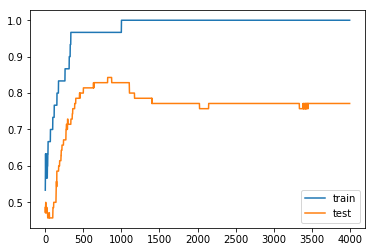

In [92]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### 3.2 MLP c dropout регуляризацией

In [93]:
from keras.layers import Dropout

In [94]:
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0)

In [96]:
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.967, Test: 0.800


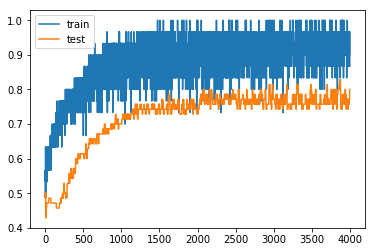

In [97]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### Задание 2.

* Ограничение веса. Обновите пример, чтобы добавить l2-регуляризациб в скрытый слой и сравните результаты.

* Повторная оценка. Обновите пример, чтобы повторить оценку модели избыточного снаряжения и отсева, суммировать и сравнивать средние результаты.

* Перебор по сетке. Определить зависимость вероятности в функции dropout от величины значения на тестовой выборке

## 4. Проблема исчезающих и взрывающихся градиентов

Проблема исчезающих градиентов является примером нестабильного поведения, с которым вы можете столкнуться при обучении глубокой нейронной сети.

* Он описывает ситуацию, когда глубокая многослойная сеть с прямой связью или рекуррентная нейронная сеть не в состоянии распространять полезную информацию о градиенте от выходного конца модели обратно к слоям около входного конца модели.

* Результатом является общая неспособность моделей со многими слоями учиться на заданном наборе данных или преждевременно сходиться к плохому решению.

* Многие исправления и обходные пути были предложены и исследованы, такие как альтернативные схемы инициализации веса, неконтролируемая предварительная подготовка, послойное обучение и изменения алгоритма градиентного спуска. 

* Возможно, наиболее распространенным изменением является использование функции линейной активации ReLu, которая стала новым must have, вместо функции активации гиперболического тангенса, которая была популярна в конце 1990-х и 2000-х годов.

Мы разберем как увидеть проблему исчезающего градиента при обучении модели нейронной сети и как ее исправить, используя альтернативную функцию активации ReLu и схему инициализации веса.

![title](img/ann24.png)

Рассмотрим нейронную сеть с 4 скрытыми слоями с одним нейроном в каждой матрице.

![title](img/ann25.png)

**Вычислительный граф** для такой сети выглядит следующим образом. 

При прямом распространении мы просто умножаем входные данные на матрицы весов и добавляем смещение, как показано выше. Затем берем сигмоидальную функцию активации

![title](img/ann26.png)

Во время  обратного распространения ошибки (backprop) мы находим производную от выхода по весам сети, чтобы уточнить результат модели. Предположим, что мы хотим найти производную матрицы весов C по b1

Условия, которые будут включены в это:

![title](img/ann27.png)

sig'(z1), sig' (z2) .. и т. д. меньше 1/4.  Потому что производная сигмоидальной функции составляет менее 1/4.

* Матрицы весов w1, w2, w3, w4 инициализируются из нормального распределения, чтобы иметь среднее значение 0 и стандартное отклонение 1. Следовательно, ||w|| меньше 1. 

* Следовательно, в производной мы умножаем множество членов, которые меньше 1 и 1/4. Следовательно, при умножении таких маленьких множителей большое количество раз мы получаем очень маленький градиент, из-за которого обучение может остановиться.

![title](img/ann25.png)

Похожая ситуация с **взрывающимися градиентами.** Если мы инициализируем наши матрицы весов очень большими значениями, то производная будет очень большой, и, следовательно, может наблюдаться нестабильное поведение при обучении

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
# generate 2d classification dataset
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
# scale input data to [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [20]:
from keras.initializers import RandomUniform

In [21]:
# define model
model = Sequential()
init = RandomUniform(minval=0, maxval=1)
model.add(Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

In [22]:
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [23]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

In [24]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.820, Test: 0.836


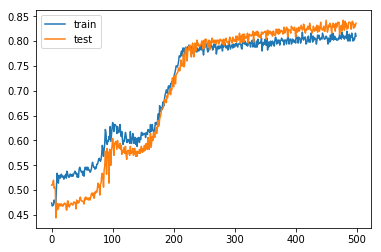

In [25]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

## 4.1 Более глубокий  MLP

In [26]:
init = RandomUniform(minval=0, maxval=1)
model = Sequential()
model.add(Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

In [27]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [28]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

In [29]:
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.582, Test: 0.550


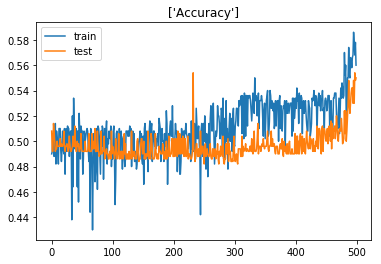

In [30]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
plt.title(["Accuracy"])
pyplot.legend()
pyplot.show()

## 4.2 Глубокий MLP с ReLu

### 4.2.1. Преимущества ReLu

ReLU является линейным для всех положительных значений и нулем для всех отрицательных значений. Это означает, что:

* Просто с вычислительной точки зрения. Таким образом, модели может потребоваться меньше времени для обучения.

* Быстрее сходимость. Линейность означает, что наклон не является плато или промежутком насыщения, когда x становится большим. 

* У ReLu нет проблемы исчезающего градиента, от которой страдают другие функции активации, такие как сигмоид или гиперболический тангес.

* Поскольку ReLU равен нулю для всех отрицательных входов. Производная также равна нулю. Бороться с этой проблемой, мы можем использовать негерметичный ReLU. Leaky ReLU гарантирует, что наклон для отрицательных значений не равен нулю.

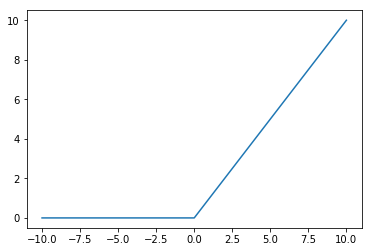

In [31]:
 # rectified linear function
def rectified(x):
    return max(0.0, x)
 
# define a series of inputs
series_in = [x for x in range(-10, 11)]
# calculate outputs for our inputs
series_out = [rectified(x) for x in series_in]
# line plot of raw inputs to rectified outputs
pyplot.plot(series_in, series_out)
pyplot.show()

### 4.2.2 Инициализация весов

**Метод инициализации Завьера (Xavier)** (иногда — метод Glorot’а). 

Основная идея этого метода — упростить прохождение сигнала через слой во время как прямого, так и обратного распространения ошибки для линейной функции активации (этот метод также хорошо работает для сигмоидной функции, так как участок, где она ненасыщена, также имеет линейный характер).

При вычислении весов этот метод опирается на вероятностное распределение (равномерное или нормальное) с дисперсией $$Var(W)= {2 \over n_{in} + n_{out}}$$, где n количества нейронов в предыдущем и последующем слоях соответственно.

**Метод инициализации Ге (He)** — это вариация метода Завьера, больше подходящая функции активации ReLU, компенсирующая тот факт, что эта функция возвращает нуль для половины области определения. А именно, в этом случае $$\mathrm{Var}(W) = {2 \over{n_{in}}}$$

In [32]:
model = Sequential()
model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [34]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=1)

Train on 500 samples, validate on 500 samples
Epoch 1/500
500/500 [==============================] - 0s 831us/step - loss: 0.6857 - acc: 0.5340 - val_loss: 0.7008 - val_acc: 0.4760
Epoch 2/500
500/500 [==============================] - 0s 78us/step - loss: 0.6837 - acc: 0.5300 - val_loss: 0.6913 - val_acc: 0.4940
Epoch 3/500
500/500 [==============================] - 0s 78us/step - loss: 0.6768 - acc: 0.5580 - val_loss: 0.6921 - val_acc: 0.4880
Epoch 4/500
500/500 [==============================] - 0s 76us/step - loss: 0.6744 - acc: 0.5640 - val_loss: 0.6878 - val_acc: 0.5080
Epoch 5/500
500/500 [==============================] - 0s 81us/step - loss: 0.6711 - acc: 0.5640 - val_loss: 0.6846 - val_acc: 0.5180
Epoch 6/500
500/500 [==============================] - 0s 79us/step - loss: 0.6695 - acc: 0.5680 - val_loss: 0.6814 - val_acc: 0.5260
Epoch 7/500
500/500 [==============================] - 0s 78us/step - loss: 0.6657 - acc: 0.5660 - val_loss: 0.6807 - val_acc: 0.5200
Epoch 8/500
500

500/500 [==============================] - 0s 68us/step - loss: 0.4488 - acc: 0.7860 - val_loss: 0.4256 - val_acc: 0.8400
Epoch 122/500
500/500 [==============================] - 0s 73us/step - loss: 0.4170 - acc: 0.8200 - val_loss: 0.4144 - val_acc: 0.8180
Epoch 123/500
500/500 [==============================] - 0s 76us/step - loss: 0.4660 - acc: 0.7780 - val_loss: 0.4364 - val_acc: 0.7940
Epoch 124/500
500/500 [==============================] - 0s 69us/step - loss: 0.4531 - acc: 0.7880 - val_loss: 0.4280 - val_acc: 0.7960
Epoch 125/500
500/500 [==============================] - 0s 69us/step - loss: 0.4146 - acc: 0.8100 - val_loss: 0.4007 - val_acc: 0.8320
Epoch 126/500
500/500 [==============================] - 0s 70us/step - loss: 0.4216 - acc: 0.8020 - val_loss: 0.5402 - val_acc: 0.7400
Epoch 127/500
500/500 [==============================] - 0s 69us/step - loss: 0.4849 - acc: 0.7820 - val_loss: 0.4526 - val_acc: 0.7780
Epoch 128/500
500/500 [==============================] - 0s 73

500/500 [==============================] - 0s 70us/step - loss: 0.3983 - acc: 0.8340 - val_loss: 0.4014 - val_acc: 0.8300
Epoch 242/500
500/500 [==============================] - 0s 67us/step - loss: 0.3967 - acc: 0.8320 - val_loss: 0.3812 - val_acc: 0.8340
Epoch 243/500
500/500 [==============================] - 0s 68us/step - loss: 0.4082 - acc: 0.8300 - val_loss: 0.3968 - val_acc: 0.8220
Epoch 244/500
500/500 [==============================] - 0s 65us/step - loss: 0.3936 - acc: 0.8400 - val_loss: 0.4043 - val_acc: 0.8160
Epoch 245/500
500/500 [==============================] - 0s 66us/step - loss: 0.4044 - acc: 0.8180 - val_loss: 0.3865 - val_acc: 0.8400
Epoch 246/500
500/500 [==============================] - 0s 67us/step - loss: 0.3967 - acc: 0.8260 - val_loss: 0.3945 - val_acc: 0.8220
Epoch 247/500
500/500 [==============================] - 0s 67us/step - loss: 0.4035 - acc: 0.8320 - val_loss: 0.4187 - val_acc: 0.7920
Epoch 248/500
500/500 [==============================] - 0s 65

500/500 [==============================] - 0s 71us/step - loss: 0.4042 - acc: 0.8220 - val_loss: 0.3886 - val_acc: 0.8320
Epoch 362/500
500/500 [==============================] - 0s 70us/step - loss: 0.3829 - acc: 0.8300 - val_loss: 0.3776 - val_acc: 0.8300
Epoch 363/500
500/500 [==============================] - 0s 69us/step - loss: 0.3863 - acc: 0.8320 - val_loss: 0.4295 - val_acc: 0.7800
Epoch 364/500
500/500 [==============================] - 0s 71us/step - loss: 0.4310 - acc: 0.8140 - val_loss: 0.3873 - val_acc: 0.8320
Epoch 365/500
500/500 [==============================] - 0s 72us/step - loss: 0.4073 - acc: 0.8160 - val_loss: 0.3855 - val_acc: 0.8340
Epoch 366/500
500/500 [==============================] - 0s 66us/step - loss: 0.3997 - acc: 0.8220 - val_loss: 0.3782 - val_acc: 0.8280
Epoch 367/500
500/500 [==============================] - 0s 67us/step - loss: 0.4136 - acc: 0.8240 - val_loss: 0.4025 - val_acc: 0.8160
Epoch 368/500
500/500 [==============================] - 0s 70

500/500 [==============================] - 0s 72us/step - loss: 0.4068 - acc: 0.8280 - val_loss: 0.4784 - val_acc: 0.7680
Epoch 482/500
500/500 [==============================] - 0s 68us/step - loss: 0.3916 - acc: 0.8320 - val_loss: 0.3980 - val_acc: 0.8160
Epoch 483/500
500/500 [==============================] - 0s 68us/step - loss: 0.3915 - acc: 0.8360 - val_loss: 0.3753 - val_acc: 0.8320
Epoch 484/500
500/500 [==============================] - 0s 67us/step - loss: 0.3848 - acc: 0.8360 - val_loss: 0.3788 - val_acc: 0.8440
Epoch 485/500
500/500 [==============================] - 0s 65us/step - loss: 0.3956 - acc: 0.8140 - val_loss: 0.4354 - val_acc: 0.7860
Epoch 486/500
500/500 [==============================] - 0s 72us/step - loss: 0.3773 - acc: 0.8420 - val_loss: 0.3872 - val_acc: 0.8240
Epoch 487/500
500/500 [==============================] - 0s 70us/step - loss: 0.3879 - acc: 0.8360 - val_loss: 0.3730 - val_acc: 0.8360
Epoch 488/500
500/500 [==============================] - 0s 67

In [35]:
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.848, Test: 0.826


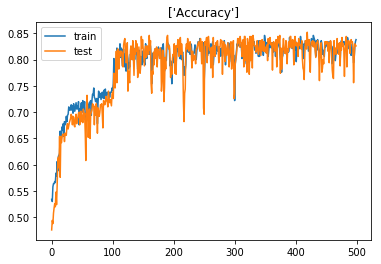

In [36]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
plt.title(["Accuracy"])
pyplot.legend()
pyplot.show()

In [37]:
from keras.callbacks import TensorBoard

In [38]:
tb = TensorBoard(histogram_freq=1, write_grads=True)

In [39]:
model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0, callbacks=[tb])

### Задание 3.

* Инициализация начальных весов. Обновите MLP, сделайте функцию активации tanh, чтобы использовать инициализацию Xavier с равномерным весом. Опишите результаты.

* Алгоритм обучения. Обновите MLP, сделайте функцию активации tanh, чтобы использовать алгоритм адаптивного обучения, такой как Адам. Опишите  результаты.

* Изменения веса. Повторите примеры с tanh и relu, чтобы записать и построить векторную норму L1 весов моделей для каждой эпохи в качестве показателя того, насколько каждый слой изменяется во время обучения. Сравните результаты

* Увеличение глубины модели. Реализуйте эксперимент, используя MLP с tanh активацией. Покажите производительность моделей при увеличении количества скрытых слоев с 1 до 10.

* Увеличьте ширину сети. Увеличьте количество нейронов в скрытых слоях MLP с tanh активации с 5 до 25 и покажите  производительность при увеличении количества слоев с 1 до 10.

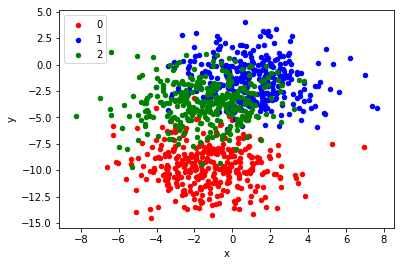

In [101]:
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from pandas import DataFrame


X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

## 5. Ансамбль нейросетей

In [123]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product

In [124]:
def fit_model(trainX, trainy):
    trainy_enc = to_categorical(trainy)
    # инициализируем модель
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # обучение модели
    model.fit(trainX, trainy_enc, epochs=500, verbose=0)
    return model
 
# делаем прогноз для ансамбля моделей
def ensemble_predictions(members, weights, testX):
    # делаем прогнозы отдельными моделями
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    # взвешенная сумма моделей в ансамбле
    summed = tensordot(yhats, weights, axes=((0),(0)))
    # argmax по классам
    result = argmax(summed, axis=1)
    return result
 
# вычисление прогноза для ансамбля моделей
def evaluate_ensemble(members, weights, testX, testy):
    # формируем прогнозы
    yhat = ensemble_predictions(members, weights, testX)
    # вычисляем точность (accuracy)
    return accuracy_score(testy, yhat)
 
# нормализация векторов весов, чтобы норма = 1
def normalize(weights):
    # вычисление l1 нормы 
    result = norm(weights, 1)
    # проверка на нули
    if result == 0.0:
        return weights
    # возвращем нормализованный вектор коэффициентов
    return weights / result
 
# поиск оптимальных весов перебором по сетке
def grid_search(members, testX, testy):
    # определяем веса
    w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    best_score, best_weights = 0.0, None
    # перебираем все возможные комбинации
    for weights in product(w, repeat=len(members)):
        # пропускаем, если все веса равны
        if len(set(weights)) == 1:
            continue
        # нормализация весов
        weights = normalize(weights)
        # расчет весов
        score = evaluate_ensemble(members, weights, testX, testy)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.3f' % (best_weights, best_score))
    return list(best_weights)

In [125]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# разбиваем на обучение и тест
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [ ]:
# обучение моделей
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# расчет для каждой модели в ансамбле
testy_enc = to_categorical(testy)
for i in range(n_members):
    _, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
    print('Model %d: %.3f' % (i+1, test_acc))
# вычисление среднего ансамбля
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)
# поиск оптимальных весов перебором по сетке
weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

##  6. Stacking нейросетей


In [140]:
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from os import makedirs

def fit_model(trainX, trainy):

    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(trainX, trainy, epochs=500, verbose=0)
    return model

In [141]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [142]:
#makedirs('models')
n_members = 5
for i in range(n_members):
    model = fit_model(trainX, trainy)
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


In [143]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
import pydot 
import graphviz

In [144]:
# загрузка моделей из файла
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'models/model_' + str(i + 1) + '.h5'
        # загрузка модели из файла
        model = load_model(filename)
        # добавка списка моделей в ансамбле
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models
 
# определение модели стекинга
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    # определение множественного входа
    ensemble_visible = [model.input for model in members]
    # объединение выхода из каждой модели
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(3, activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # вывод графика стэкинга
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # компиляция
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# обучение модели стекинга
def fit_stacked_model(model, inputX, inputy):
    # подгоовка входных данных
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    # обучение модели
    model.fit(X, inputy_enc, epochs=300, verbose=0)
    
def predict_stacked_model(model, inputX):
    # подготовка входных данных
    X = [inputX for _ in range(len(model.input))]
    # делаем предикт
    return model.predict(X, verbose=0)

In [145]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# разбиваем на обучение и тест
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


#### Комментарий: Установите pydot и graphviz для визуализации структуры нейронной сети, либо отключите функцию plot_model

In [ ]:
# загрузка всех моделей
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# определение стекинга моделей
stacked_model = define_stacked_model(members)
# обучение модели стекинга
fit_stacked_model(stacked_model, testX, testy)
# предикт модели стекинга
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

### Задание 4. 
* Разобраться с ансамблями и стекингом.
* Применить для своей задачи классификации.